<a href="https://colab.research.google.com/github/TakshPanchal/jax_notebooks/blob/main/simple_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement two hidden layers neural network classifier from scratch in JAX [20 Marks]

- [X] Two hidden layers here means (input - hidden1 - hidden2 - output).
- [X]  You must not use flax, optax, or any other library for this task.
- [X]  Use MNIST dataset with 80:20 train:test split.
- [X]  Manually optimize the number of neurons in hidden layers.
- [X]  Use gradient descent from scratch to optimize your network. You should use the Pytree concept of JAX to do this elegantly.
- [X]  Plot loss v/s iterations curve with matplotlib.
- [ ]  Evaluate the model on test data with various classification metrics and briefly discuss their implications.


# Two hidden layered neural network or Multi Layered Percepron

This notebook will cover implementation of simple neural network with hidden layers or multilayer perceptron(MLP). MNIST dataset will be used to train the network. These are the topics which will be covered
- Loading of MNIST dataset
- Implementation of MLP in JAX library
- Implementation Gradient Decend algorithm
- Analysis of loss v/s epochs curve
- Evaluvate model will various classification metrics

## Packages

Let's first import all the packages which will be needed.

- `jax` is Autograd and XLA, brought together for high-performance machine learning research.
- We will use `jax.numpy` api for calculations. 
- `matplotlib` is a library to plot graphs in Python.
- `tqdm` tqdm is a library which is used for creating Progress Bars
- we will use `sklearn` for train-test split and data loading
- `seed` is used to keep all the random function calls consistent.


In [164]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, vmap, random
from tqdm import trange
from sklearn.datasets import load_digits # for loading MNIST dataset
from sklearn.model_selection import train_test_split

seed = 82

## Loading MNIST dataset

The MNIST dataset contains images of labeled handwritten digits.It is an extremely good dataset for people who want to try machine learning techniques on real-world data while spending minimal time and effort on data preprocessing and formatting. `sklearn` library's `load_digits` function helps load the images and labels directly as `numpy` array.

`load_digits` function returns a `dict` which contains metadata and data of datasets. Use `'images'` and `'target'` keys to get images and labels 

In [165]:
mnist = load_digits() # returns dictionary
print(mnist.keys())

# Description of mnist dataset
# print(mnist['DESCR']) 

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [166]:
images = mnist['images']
labels = mnist['target']

n_images = images.shape[0]
im_shape = images[0].shape
n_classes = len(mnist['target_names'])
print("Total no. of images are ", n_images)
print("Shape of a image is",im_shape)

Total no. of images are  1797
Shape of a image is (8, 8)


We can see some images by running next cell. 

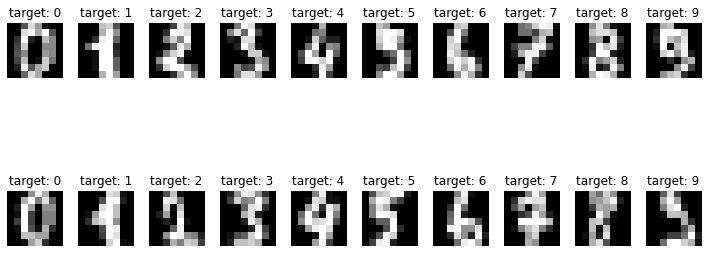

In [167]:
fig, axes = plt.subplots(2, 10, figsize=(10, 6))
for i in range(20):
    axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")
    
plt.tight_layout()

We know that each image is made of pixels and a image can be represeted as a matrix. Bellow image is a close look of a grayscale image. Each pixel is has a value which represents it's brightness. This image can be represented as a 2-d matrix.

<p align="center">
  <img src="https://www.saraai.com/images/blog/mnist1.png" />
</p>
In our dataset, we have grayscale images of 8X8 pixels.

### Split data in train and test

The train-test split technique is used to evaluate model performance after training. 

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

- **Train Dataset**: Used to fit the machine learning model.

- **Test Dataset**: Used to evaluate the fit machine learning model.
The objective is to estimate the performance of the machine learning model on 
- **unseen data**: data not used to train the model.

In practice, model is expected for prediction on new unseen data. That is why we make a subset of unseen data for evaluation of model.

Here we are doing 80:20 split for train and test data



In [168]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=seed)
# images = images.reshape(n_images,-1)
# images = (images - images.min()) / (images.max() - images.min())
print("Train size : ",X_train.shape[0])
print("Test size  : ",X_test.shape[0])

Train size :  1437
Test size  :  360


## Multi Layer Perceptron

Before moving to implementation let us remember some concepts of Multilayer perceptron(MLP). 

MLP is feedforward neural network which has structure like this. It contains input,output and some hidden layers which may have different dimensions. It can be used for classfication as well as regression problem

<p align="center">
  <img src="https://nasirml.files.wordpress.com/2017/12/mlp2_model.png?w=585&h=272" />
</p>

<p>
This is image of neural network of two hidden layers. The first layer is called **Input layer** which consists data from the sample. Also, input layer does not contain any paramers. The last layer is **Output layer** which is prediction of the network.
Different arrow represents linear tranformation followed by non-linear activation. </p>
<p> 
Input layer dimensions are decided from the shape of input data and Output layer dimensions are decided based on the number of labels or classes. Hidden layer dimensions are hyperparameters and can be changed on base of model performance.
</p>


---


Linear Transformation can be defined by following equation.


$$Z^{[l]} = W^{[l]} \cdot A^{[l-1]} +b^{[l]}\tag{1}$$

where 
$A^{[0]} = X$ and Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer 

In this equation $W$ is known as weight and $b$ is bias.

For one dimention Eq. $(1)$ can be simplify as equation of line which we have already studied. 

$$y=w ⋅ x + b\tag{2}$$

So, now you understand that you recall linear transformation, let's understand about non-linear activation

**Activation Function**
As I mentioned before, activation functions are basically non-linear transformation applied after linear tranformation. After applying activation output will be send to next layer of neurons or it may be the final prediction.

There are different type of activation functions but most common activation functions used in Deep Learning are mentioned bellow:
- [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
- [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function)
- [softmax](https://en.wikipedia.org/wiki/Softmax_function)
- tanh

Activation functions adds non-linearity which helps to learn more complex patterns in the data. Each activation function mentioned here has certain use cases. We will use ReLU and softmax for our MLP model. You will learn more about those later. 


**Type of problem**
We also have to identify that which type of problem is this. Is it a classfication problem or regression? if it is classfication then, Is it a binary or multi-class or multi-label?

we know that we have to predict a discreate number from a image which means we have to classify the images. So that this is a classfication problem

**binary classification** - no. of classes will be only two

**multi-class classfication** - no. of classes are more than two and each sample maps to only one class

**multi-lable classification** - no. of classes are more than two and each sample may maps to more than one classes


In our dataset, each image correspondence to a number so we are dealing with **multi-class classification problem**.

## Implementation of Model

At first, we have to define parameters of the model i.e. weights and biases for each layer. Remember input layer does not have any parameters.

In [169]:
def init_params(layer_sizes,seed=42):
    """
    Initiate parameters of MLP model.

    Args:
    layer_sizes -- list of sizes of layers starting from input layer to output layer
    seed -- interger, seed for random number generation
    
    Returns:
    params -- pytree of weights and biases of the layers
    """
    n_layers = len(layer_sizes)
    parent_key = random.PRNGKey(seed)
    params = []
    keys = random.split(parent_key,num = n_layers - 1)  

    for i in range(n_layers-1):
        w_key,b_key = random.split(keys[i])
        in_size = layer_sizes[i]
        out_size = layer_sizes[i+1]

        weights = random.normal(w_key,shape=(in_size, out_size))
        biases = random.normal(b_key,shape=(out_size,))
        params.append(dict(weights=weights,biases=biases))
    return params


In [170]:
def forward(params, x):
    """forward propagation for a single sample

    Args:
    params -- parameters pytree of the model
    x -- numpy feature vector of a sample

    Returns:
    output -- post activation value of last layer"""
    activation = x  # x will be input for next hidden layer

    hidden_layers = params[:-1] 

    # Loop over the hidden layers with ReLU activation
    for layer in hidden_layers:
        z = np.dot(activation, layer['weights']) + layer['biases']
        activation = jax.nn.relu(z)

    # Perform final transformation with softmax activation
    last_layer = params[-1]
    logits = np.dot(activation, last_layer['weights']) + last_layer['biases']
    output = jax.nn.log_softmax(logits)

    return output

batch_forward = jit(vmap(forward, in_axes=(None, 0))) # forward propagation for a batch


### Multi-class Cross-entropy loss
This loss is used in multi-class classfication task. Formula of it is mentioned bellow.
$$-\sum_{k=1}^Ky^k \log(\hat{y}^k)$$

Here,  $y^k$  is 0 or 1, indicating whether class label $k$ is the correct classification


In [171]:
@jit
def loss_fn(params, X, Y):
    """ Compute the multi-class cross-entropy loss """
    prediction = batch_forward(params, X)
    return -np.sum(Y * prediction)


### Gradient Descent
gradient descent is the heart of neural network.Gradient descent algorithm calculates gradients with respect of paramerts and update parameter based on gradients. 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

Here, Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer 


In [172]:
@jit
def grad_calculation(params, X, Y):
    """calculate gradients of parameters

    Args:
        params (list): parameters of the model
        X (array type): input matrix of batch which has shape (n_samples, n_features)
        Y (array type): one hot encoded true matrix of shape (n_samples, n_)

    Returns:
        list: gradients of parameters
    """
    gradients = jax.grad(loss_fn)(params, X, Y)
    return gradients

def update_param(p,g,lr = 1e-5):
    """update parameters of the model

    Args:
        p (array like): matrix of a parameter
        g (array like): gradient of the same parameter
        lr (float, optional): learning rate. Defaults to 1e-5.

    Returns:
        array like: updated parameter matrix
    """
    return p - lr * g

@jit
def gradient_decend(params,gradients):
    """Gradient decend algorithm which minimizes loss by updating parameters.

    Args:
        params (list): parameters of the model
        gradients (list): gradients of parameters

    Returns:
        array like: updated parameters
    """
    return jax.tree_map(
        update_param,
        params, gradients
    )


In [173]:
def predict(params, X):
    """predicts class from the sample.

    Args:
        params (list): parameters of the model
        X (array like): Input feaure matrix of a sample or a batch having shape (n_samples, n_features)

    Returns:
        array like: predicted class matrix having shape of (n_samples, n_classes)
    """
    predictions = batch_forward(params,X)
    labels = np.argmax(predictions, axis=-1)
    return labels

def accuracy(params, X, Y):
    """accuracy metric for classfication model

    Args:
        params (list): parameters of the model
        X (array like): Input feaure matrix of a sample or a batch having shape (n_samples, n_features)
        Y (array like): True class labels matrix having shape of (n_samples, n_classes)

    Returns:
        float: accuracy of the model on given data
    """
    Y_hat = predict(params, X)
    return np.mean(Y == Y_hat)


### Training loop

In [174]:
def train(train_images, train_labels, params, epochs = 10, batch_size = 256):
    """traing loop for MLP model

    Args:
        train_images (array like): numpy array of train data images
        train_labels (numpy array): array of train labels
        params (_type_): _description_
        epochs (int, optional): number of epochs for the training. Defaults to 10.
        batch_size (int, optional): batch size for training. Defaults to 256.
    Returns:
        list: trained parameters of the model
    """
    # print(params)
    n_samples = train_images.shape[0]
    train_losses = []
    
    # loop over epochs
    for _ in trange(epochs):
        total_loss = 0  # total loss per epoch
        # loop over batches
        for batch_i in range(0, n_samples, batch_size):
            # slice batch data
            batch_end_idx = batch_i + batch_size if not batch_i + batch_size > n_samples + 1 else -1
            batch_images = train_images[batch_i: batch_end_idx]
            batch_labels = train_labels[batch_i: batch_end_idx]            

            # push NumPy explicitly to GPU
            batch_images = jax.device_put(batch_images) 
            batch_labels = jax.device_put(batch_labels)

            loss = loss_fn(params, batch_images, batch_labels) 
            grads = grad_calculation(params, batch_images, batch_labels)
            params = gradient_decend(params,grads)
            
            total_loss += loss

        train_losses.append(total_loss)

    return params, train_losses


In [175]:
def evaluate(eval_images,true_labels, params):
    """evaluate model on a give data

    Args:
        eval_images (array like): array of evaluation data images of shape (n_samples, n_features)
        true_labels (_type_): True class labels matrix having shape of (n_samples, 1)
        params (list): parameters of the model
    Returns:
        loss (float) : Loss for the given data
        accuracy (float): Accuracy for the given data
    """
    y_train_encoded = jax.nn.one_hot(y_train, n_classes)
    eval_loss = loss_fn(params, eval_images, y_train_encoded)
    
    eval_accuracy = accuracy(params, eval_images, true_labels)
    
    print("Accuracy of the model is ", eval_accuracy)
    print("Loss of the model is ", eval_loss)
    return eval_loss, eval_accuracy 


In [ ]:
epochs = 1000
batch_size = 256
n_features = im_shape[0] * im_shape[1]
layers = [n_features, 32, 32, n_classes]

params = init_params(layers,42)  
print("Layers shapes are - ", jax.tree_map(lambda p: p.shape,params))

X_train_flattern = X_train.reshape(-1, n_features) # one hot encode labels encode labels 
y_train_encoded = jax.nn.one_hot(y_train, n_classes) # flattern inputs 

params, loss_train = train(X_train_flattern, y_train_encoded, params, epochs = epochs)

Layers shapes are -  [{'biases': (32,), 'weights': (64, 32)}, {'biases': (32,), 'weights': (32, 32)}, {'biases': (10,), 'weights': (32, 10)}]


 54%|█████▎    | 535/1000 [00:09<00:11, 40.62it/s]

In [ ]:
eval_loss, eval_acc = evaluate(X_train_flattern, y_train, params)

In [ ]:
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, loss_train, 'g', label='Training loss')
# plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()